In [ ]:
# Integrated Multi-Topology PUEA Detection System
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import kneighbors_graph
import warnings
import os
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from tqdm import tqdm
import random

warnings.filterwarnings('ignore')

print("=== INTEGRATED MULTI-TOPOLOGY PUEA DETECTION SYSTEM ===")
print("Hierarchy: Topology -> Scenarios(A,B,C) -> Cases(10,20,30,40,50%) -> Clustering -> Classification -> DR & FDR")

# Configuration parameters
NUM_TOPOLOGIES = 75 # Number of different network topologies to simulate
NUM_SECONDARY_USERS = 30
AREA_SIZE = 150
NUM_TIME_SLOTS = 400 # Time slots per scenario per topology

# Create comprehensive results directory structure
main_results_dir = "integrated_topology_results"
if not os.path.exists(main_results_dir):
    os.makedirs(main_results_dir)

# Create subdirectories for organized results
subdirs = ["topology_data", "clustering_results", "classification_results", "final_analysis", "visualizations"]
for subdir in subdirs:
    full_path = os.path.join(main_results_dir, subdir)
    if not os.path.exists(full_path):
        os.makedirs(full_path)

print(f"✅ System configured for {NUM_TOPOLOGIES} topologies with comprehensive analysis pipeline")

# Global storage for all results across all topologies
ALL_TOPOLOGY_RESULTS = {
    'topology_id': [],
    'scenario': [],
    'case_percentage': [],
    'clustering_method': [],
    'classification_method': [],
    'detection_rate': [],
    'false_detection_rate': [],
    'pu_position': [],
    'puea_position': [],
    'pu_puea_distance': []
}

def calculate_distance(point1, point2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt(np.sum((point1 - point2)**2))

def calculate_received_power(tx_power, distance, path_loss_exp, shadowing):
    """Calculate received power using path loss model"""
    path_loss = 10 * path_loss_exp * np.log10(distance + 1e-6)
    received_power = tx_power - path_loss + shadowing
    return received_power

def extract_enhanced_features(received_powers):
    """Extract statistical features from received power measurements"""
    mean = np.mean(received_powers)
    variance = np.var(received_powers)
    median = np.median(received_powers)
    lower_quartile = np.percentile(received_powers, 25)
    upper_quartile = np.percentile(received_powers, 75)
    return [mean, variance, median, lower_quartile, upper_quartile]

print("✅ Core functions and global storage initialized")

=== INTEGRATED MULTI-TOPOLOGY PUEA DETECTION SYSTEM ===
Hierarchy: Topology -> Scenarios(A,B,C) -> Cases(10,20,30,40,50%) -> Clustering -> Classification -> DR & FDR
✅ System configured for 75 topologies with comprehensive analysis pipeline
✅ Core functions and global storage initialized


In [ ]:
# Manhattan Distance Matrix Calculation Functions
def calculate_manhattan_distance_matrix(features):
    """
    Calculate Manhattan (cityblock) distance matrix from feature data

    Args:
        features: numpy array of shape (n_samples, n_features)

    Returns:
        distance_matrix: square matrix of pairwise Manhattan distances
    """
    try:
        # Calculate pairwise Manhattan distances
        distances = pdist(features, metric='cityblock')

        # Convert to square distance matrix
        distance_matrix = squareform(distances)

        # Round to reasonable precision
        distance_matrix = np.round(distance_matrix, 4)

        return distance_matrix
    except Exception as e:
        print(f"Error calculating Manhattan distance matrix: {str(e)}")
        n_samples = features.shape[0]
        return np.zeros((n_samples, n_samples))

def save_distance_matrices_for_scenario(features, labels, scenario_name, case_percentage, output_dir="distance_matrices"):
    """
    Save distance matrix and feature data for a specific scenario case

    Args:
        features: feature array
        labels: label array
        scenario_name: scenario identifier (A, B, C)
        case_percentage: PUEA percentage (10, 20, 30, 40, 50)
        output_dir: directory to save matrices
    """
    try:
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Calculate distance matrix
        distance_matrix = calculate_manhattan_distance_matrix(features)

        # Create combined data with features and labels
        combined_data = np.column_stack((features, labels))
        feature_columns = ['mean', 'variance', 'median', 'q1', 'q3']
        all_columns = feature_columns + ['Label']

        # Save as CSV files
        scenario_key = f"{scenario_name}_{case_percentage}"

        # Save distance matrix
        dist_file = os.path.join(output_dir, f"{scenario_key}_manhattan_dist.csv")
        pd.DataFrame(distance_matrix).to_csv(dist_file, index=False)

        # Save feature data with labels
        data_file = os.path.join(output_dir, f"{scenario_key}_case_{case_percentage}percent_matrix.csv")
        pd.DataFrame(combined_data, columns=all_columns).to_csv(data_file, index=False)

        print(f"✅ Saved distance matrix and data for {scenario_key}")

        return distance_matrix, combined_data

    except Exception as e:
        print(f"❌ Error saving matrices for {scenario_name}_{case_percentage}: {str(e)}")
        return None, None

def create_distance_matrices_for_topology(topology_results, topology_id):
    """
    Create and save distance matrices for all scenarios in a topology

    Args:
        topology_results: results from run_single_topology_simulation
        topology_id: topology identifier
    """
    try:
        # Create topology-specific directory
        topology_dir = os.path.join(main_results_dir, "distance_matrices", f"topology_{topology_id}")
        if not os.path.exists(topology_dir):
            os.makedirs(topology_dir)

        distance_matrices = {}

        # Process each unique scenario-case combination
        processed_combinations = set()

        for result in topology_results:
            scenario = result['scenario']
            percentage = result['case_percentage']
            combination_key = f"{scenario}_{percentage}"

            if combination_key not in processed_combinations:
                # Note: In the integrated system, we would need to regenerate or store
                # the feature data to create distance matrices. For now, we'll create
                # a placeholder that shows the structure.

                print(f"  Creating distance matrix for Scenario {scenario}, {percentage}% PUEA")

                # This would be replaced with actual feature data in a full implementation
                # For demonstration, we'll create a summary entry
                distance_matrices[combination_key] = {
                    'scenario': scenario,
                    'percentage': percentage,
                    'topology_id': topology_id,
                    'pu_puea_distance': result['pu_puea_distance']
                }

                processed_combinations.add(combination_key)

        # Save summary of distance matrices for this topology
        summary_file = os.path.join(topology_dir, "distance_matrix_summary.csv")
        summary_df = pd.DataFrame(list(distance_matrices.values()))
        summary_df.to_csv(summary_file, index=False)

        print(f"✅ Distance matrix summary saved for topology {topology_id}")

        return distance_matrices

    except Exception as e:
        print(f"❌ Error creating distance matrices for topology {topology_id}: {str(e)}")
        return {}

print("✅ Manhattan distance matrix calculation functions loaded")
print("📏 Functions available:")
print("   • calculate_manhattan_distance_matrix(): Calculate distance matrix from features")
print("   • save_distance_matrices_for_scenario(): Save matrices for specific scenarios")
print("   • create_distance_matrices_for_topology(): Process all scenarios in a topology")# Enhanced Clustering and Classification Functions
def perform_enhanced_spectral(distance_matrix, n_clusters=2):
    """Simple but effective Spectral Clustering improvements
    
    Key improvements:
    1. Data-driven sigma calculation instead of fixed percentiles
    2. Better cluster balance validation
    3. Multiple sigma attempts for robustness
    """
    try:
        n = distance_matrix.shape[0]
        best_labels = None
        best_balance = 0
        
        # Calculate good sigma values from actual data distances
        distances = distance_matrix[distance_matrix > 0]  # Remove zeros
        
        if len(distances) == 0:
            return np.random.randint(0, n_clusters, size=n)
        
        # Try different sigma values based on data statistics
        mean_dist = np.mean(distances)
        std_dist = np.std(distances)
        median_dist = np.median(distances)
        
        # Multiple sigma strategies
        sigma_values = [
            median_dist,                    # Median-based
            mean_dist,                      # Mean-based  
            np.percentile(distances, 25),   # Lower quartile
            np.percentile(distances, 75),   # Upper quartile
            mean_dist + 0.5 * std_dist,     # Mean + 0.5*std
            mean_dist - 0.5 * std_dist      # Mean - 0.5*std
        ]
        
        # Remove invalid sigma values
        sigma_values = [s for s in sigma_values if s > 0]
        
        # Try each sigma value
        for sigma in sigma_values:
            try:
                # Create RBF affinity matrix
                affinity = np.exp(-distance_matrix**2 / (2 * sigma**2))
                
                # Ensure diagonal is 1 and matrix is symmetric
                np.fill_diagonal(affinity, 1.0)
                affinity = (affinity + affinity.T) / 2
                
                # Apply spectral clustering
                spectral = SpectralClustering(
                    n_clusters=n_clusters,
                    affinity='precomputed',
                    random_state=42,
                    assign_labels='kmeans'  # More stable than discretize
                )
                labels = spectral.fit_predict(affinity)
                
                # Check cluster balance (avoid very unbalanced clusters)
                if len(np.unique(labels)) == n_clusters:
                    unique_labels, counts = np.unique(labels, return_counts=True)
                    balance = min(counts) / max(counts)  # 1.0 = perfectly balanced
                    
                    # Prefer balanced clusters (threshold: at least 20% in smaller cluster)
                    if balance >= 0.2 and balance > best_balance:
                        best_balance = balance
                        best_labels = labels.copy()
                        
            except Exception:
                continue
        
        return best_labels if best_labels is not None else np.random.randint(0, n_clusters, size=n)
        
    except Exception as e:
        return np.random.randint(0, n_clusters, size=distance_matrix.shape[0])

def perform_improved_agglomerative(distance_matrix, n_clusters=2):
    """Simple but effective Agglomerative clustering improvements
    
    Key improvements:
    1. Preference for 'average' linkage (works best for PUEA detection)
    2. Better cluster balance validation
    3. Fallback strategy for robustness
    """
    try:
        best_labels = None
        best_balance = 0
        
        # Try different linkage methods with preference order
        linkage_methods = ['average', 'complete', 'single', 'ward']
        
        for linkage in linkage_methods:
            try:
                # Ward linkage requires euclidean metric, others can use precomputed
                if linkage == 'ward':
                    # For ward, we need to skip if using precomputed distance
                    # Ward works better with raw features, so skip for now
                    continue
                
                agg = AgglomerativeClustering(
                    n_clusters=n_clusters,
                    linkage=linkage,
                    metric='precomputed'
                )
                labels = agg.fit_predict(distance_matrix)
                
                # Check cluster balance (avoid very unbalanced clusters)
                if len(np.unique(labels)) == n_clusters:
                    unique_labels, counts = np.unique(labels, return_counts=True)
                    balance = min(counts) / max(counts)  # 1.0 = perfectly balanced
                    
                    # Prefer more balanced clustering, with preference for better linkage methods
                    score = balance
                    if linkage == 'average':
                        score += 0.2  # Strong bonus for average linkage (works best for PUEA)
                    elif linkage == 'complete':
                        score += 0.1  # Small bonus for complete linkage
                    
                    # Only accept reasonably balanced clusters (at least 15% in smaller cluster)
                    if balance >= 0.15 and score > best_balance:
                        best_balance = score
                        best_labels = labels.copy()
                        
            except Exception:
                continue
        
        return best_labels if best_labels is not None else np.random.randint(0, n_clusters, size=distance_matrix.shape[0])
        
    except Exception as e:
        return np.random.randint(0, n_clusters, size=distance_matrix.shape[0])

def perform_enhanced_kmeans(features, n_clusters=2):
    """Enhanced K-means clustering"""
    try:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)

        best_labels = None
        best_inertia = float('inf')

        for seed in range(5):
            kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init=10)
            labels = kmeans.fit_predict(scaled_features)

            if len(np.unique(labels)) == 2 and kmeans.inertia_ < best_inertia:
                best_inertia = kmeans.inertia_
                best_labels = labels

        return best_labels if best_labels is not None else np.random.randint(0, 2, size=len(features))
    except:
        return np.random.randint(0, 2, size=len(features))

def knn_algorithm_exact(CandSet, D, distance_matrix, R=5):
    """KNN Algorithm - Exact implementation"""
    n = len(D)
    outliers = []

    for i in CandSet:
        temp = [0] * n
        cCand = 0
        cNormal = 0

        distances_with_indices = []
        for j in range(n):
            if j != i:
                distances_with_indices.append((distance_matrix[i][j], j))

        distances_with_indices.sort(key=lambda x: x[0])

        for idx, (_, point_idx) in enumerate(distances_with_indices):
            if idx < len(temp):
                temp[idx] = point_idx

        for j in range(min(R, len(distances_with_indices))):
            neighbor_idx = temp[j]
            if neighbor_idx in CandSet:
                cCand += 1
            else:
                cNormal += 1

        if cCand > cNormal:
            outliers.append(i)

    return outliers

def means_algorithm_exact(CandSet, D, NormalSet, distance_matrix):
    """Means Algorithm - Exact implementation"""
    n = len(D)
    CandDist = [0] * n
    NormDist = [0] * n
    TotalCandDist = 0
    TotalNormDist = 0

    for i in CandSet:
        for j in range(n):
            CandDist[i] += distance_matrix[i][j]
        TotalCandDist += CandDist[i]

    for i in NormalSet:
        for j in range(n):
            NormDist[i] += distance_matrix[i][j]
        TotalNormDist += NormDist[i]

    refined_CandSet = set(CandSet)
    refined_NormalSet = set(NormalSet)
    current_TotalCandDist = TotalCandDist
    current_TotalNormDist = TotalNormDist

    candidates_to_check = list(CandSet)

    for i in candidates_to_check:
        if i not in refined_CandSet:
            continue

        CandDistMeans = current_TotalCandDist / len(refined_CandSet) if len(refined_CandSet) > 0 else 0
        NormDistMeans = current_TotalNormDist / len(refined_NormalSet) if len(refined_NormalSet) > 0 else 0

        cand_diff = abs(CandDistMeans - CandDist[i])
        norm_diff = abs(NormDistMeans - NormDist[i])

        if cand_diff > norm_diff:
            refined_CandSet.remove(i)
            refined_NormalSet.add(i)
            current_TotalCandDist -= CandDist[i]
            current_TotalNormDist += CandDist[i]

    return list(refined_CandSet), list(refined_NormalSet)

def calculate_detection_metrics(true_labels, cluster_labels, pu_cluster, puea_cluster):
    """Calculate detection rate and false detection rate"""
    try:
        mapped_predictions = np.where(cluster_labels == puea_cluster, 1, 0)

        total_puea = np.sum(true_labels == 1)
        total_pu = np.sum(true_labels == 0)

        correctly_detected_puea = np.sum((true_labels == 1) & (mapped_predictions == 1))
        pu_detected_as_puea = np.sum((true_labels == 0) & (mapped_predictions == 1))

        detection_rate = correctly_detected_puea / total_puea if total_puea > 0 else 0
        false_detection_rate = pu_detected_as_puea / total_pu if total_pu > 0 else 0

        return detection_rate, false_detection_rate
    except:
        return 0.0, 1.0
    
# --- Start of New Code ---

def identify_clusters_by_centroid(cluster_labels, case_features):
    """
    Identifies PU and PUEA clusters based on centroid analysis.

    This method is more robust than the size-based heuristic. It assumes the PUEA
    transmits at a higher power, which will be reflected in the first feature
    ('mean' of received power).

    Args:
        cluster_labels (np.array): The labels assigned by the clustering algorithm.
        case_features (np.array): The feature data used for clustering.

    Returns:
        tuple: A tuple containing (pu_cluster_label, puea_cluster_label).
               Returns (0, 1) as a fallback if analysis fails.
    """
    try:
        # Get the two unique cluster identifiers (e.g., 0 and 1)
        unique_labels = np.unique(cluster_labels)
        if len(unique_labels) != 2:
            # Fallback if clustering didn't produce exactly two clusters
            return 0, 1

        label_0, label_1 = unique_labels[0], unique_labels[1]

        # Separate the feature data into two groups based on cluster labels
        features_cluster_0 = case_features[cluster_labels == label_0]
        features_cluster_1 = case_features[cluster_labels == label_1]

        # Calculate the centroid (mean vector) for each cluster
        centroid_0 = np.mean(features_cluster_0, axis=0)
        centroid_1 = np.mean(features_cluster_1, axis=0)

        # The first feature (index 0) is the 'mean' received power.
        # The PUEA cluster should have a higher mean power.
        mean_power_0 = centroid_0[0]
        mean_power_1 = centroid_1[0]

        if mean_power_1 > mean_power_0:
            # Cluster 1 is the PUEA cluster
            puea_cluster = label_1
            pu_cluster = label_0
        else:
            # Cluster 0 is the PUEA cluster
            puea_cluster = label_0
            pu_cluster = label_1

        return pu_cluster, puea_cluster

    except Exception as e:
        print(f"⚠️ Centroid analysis failed: {e}. Falling back to default labels.")
        # Fallback in case of any error (e.g., a cluster is empty)
        return 0, 1


print("✅ Enhanced clustering and classification functions loaded")
print("🔧 CLUSTERING IMPROVEMENTS APPLIED:")
print("   • Spectral: Data-driven sigma calculation, better balance validation")
print("   • Agglomerative: Preference for 'average' linkage, balance thresholds")
print("   • Expected: DR improvement to ~60-80%, FDR reduction to ~15-25%")

✅ Manhattan distance matrix calculation functions loaded
📏 Functions available:
   • calculate_manhattan_distance_matrix(): Calculate distance matrix from features
   • save_distance_matrices_for_scenario(): Save matrices for specific scenarios
   • create_distance_matrices_for_topology(): Process all scenarios in a topology
✅ Enhanced clustering and classification functions loaded


In [ ]:
# Main Simulation Loop: Topology -> Scenarios -> Cases -> Clustering -> Classification
def run_single_topology_simulation(topology_id):
    """Run complete simulation for a single topology"""

    print(f"\n{'='*60}")
    print(f"TOPOLOGY {topology_id + 1}/{NUM_TOPOLOGIES}")
    print(f"{'='*60}")

    # Set unique seed for this topology
    topology_seed = topology_id * 1000
    np.random.seed(topology_seed)

    # Define target distances for each scenario (consistent across all topologies)
    target_distances = {
        'A': 100.0,  # Far distance
        'B': 65.0,   # Medium distance
        'C': 30.0    # Close distance
    }

    # Generate scenarios with fixed distances but varying positions
    scenarios = {}

    for scenario_name, target_distance in target_distances.items():
        # Generate random center position for this topology-scenario combination
        center_x = np.random.uniform(target_distance + 10, AREA_SIZE - target_distance - 10)
        center_y = np.random.uniform(target_distance + 10, AREA_SIZE - target_distance - 10)

        # Generate random angle for this topology-scenario combination
        angle = np.random.uniform(0, 2 * np.pi)

        # Calculate PU and PUEA positions at exact target distance
        half_distance = target_distance / 2
        primary_position = np.array([
            center_x - half_distance * np.cos(angle),
            center_y - half_distance * np.sin(angle)
        ])
        puea_position = np.array([
            center_x + half_distance * np.cos(angle),
            center_y + half_distance * np.sin(angle)
        ])

        # Ensure positions are within bounds
        primary_position = np.clip(primary_position, 10, AREA_SIZE - 10)
        puea_position = np.clip(puea_position, 10, AREA_SIZE - 10)

        # Store scenario with description
        distance_descriptions = {
            'A': 'Far distance (100 units)',
            'B': 'Medium distance (65 units)',
            'C': 'Close distance (30 units)'
        }

        scenarios[scenario_name] = {
            'primary_position': primary_position,
            'puea_position': puea_position,
            'target_distance': target_distance,
            'description': distance_descriptions[scenario_name]
        }

    # Generate secondary user positions ONCE for all scenarios (constant across all topologies and scenarios)
    # Use a fixed seed to ensure consistency across all topologies
    np.random.seed(12345)  # Fixed seed for consistent secondary user positions
    secondary_positions = np.random.uniform(0, AREA_SIZE, size=(NUM_SECONDARY_USERS, 2))

    topology_results = []

    # Process each scenario
    for scenario_name, scenario_config in scenarios.items():
        print(f"\n--- Scenario {scenario_name}: {scenario_config['description']} ---")

        primary_position = scenario_config['primary_position']
        puea_position = scenario_config['puea_position']
        pu_puea_distance = calculate_distance(primary_position, puea_position)

        # Use the same secondary user positions for all scenarios (no longer generated per scenario)
        print(f"  Using constant secondary user positions across all topologies and scenarios")

        # Generate signal data for this scenario
        pu_features, puea_features = generate_scenario_data(
            primary_position, puea_position, secondary_positions, NUM_TIME_SLOTS
        )

        # Process different PUEA percentages
        puea_percentages = [10, 20, 30, 40, 50]

        for percentage in puea_percentages:
            print(f"  Processing {percentage}% PUEA case...")

            # Create case data
            num_puea_samples = max(1, int(round(NUM_TIME_SLOTS * (percentage / 100))))
            num_pu_samples = NUM_TIME_SLOTS - num_puea_samples

            # Shuffle and select samples
            np.random.seed(topology_seed + percentage)
            pu_shuffled = pu_features.copy()
            puea_shuffled = puea_features.copy()
            np.random.shuffle(pu_shuffled)
            np.random.shuffle(puea_shuffled)

            selected_pu_features = pu_shuffled[:num_pu_samples]
            selected_puea_features = puea_shuffled[:num_puea_samples]

            # Combine and create final dataset
            case_features = np.vstack((selected_pu_features[:, :-1], selected_puea_features[:, :-1]))
            case_labels = np.hstack((selected_pu_features[:, -1], selected_puea_features[:, -1]))

            # Calculate distance matrix using Manhattan distance function from cell 2
            distance_matrix = calculate_manhattan_distance_matrix(case_features)

            # Apply clustering methods
            clustering_methods = {
                'kmeans': lambda: perform_enhanced_kmeans(case_features),
                'agglomerative': lambda: perform_improved_agglomerative(distance_matrix),
                'spectral': lambda: perform_enhanced_spectral(distance_matrix)
            }

            for clustering_name, clustering_func in clustering_methods.items():
                cluster_labels = clustering_func()

                # Identify PU and PUEA clusters
                unique_clusters = np.unique(cluster_labels)
                if len(unique_clusters) == 2:
                    # Use robust centroid analysis to identify clusters
                    pu_cluster, puea_cluster = identify_clusters_by_centroid(cluster_labels, case_features)


                    # Original clustering performance
                    dr_orig, fdr_orig = calculate_detection_metrics(case_labels, cluster_labels, pu_cluster, puea_cluster)

                    # Store original clustering results
                    result_entry = {
                        'topology_id': topology_id,
                        'scenario': scenario_name,
                        'case_percentage': percentage,
                        'clustering_method': clustering_name,
                        'classification_method': 'original',
                        'detection_rate': dr_orig,
                        'false_detection_rate': fdr_orig,
                        'pu_position': primary_position.tolist(),
                        'puea_position': puea_position.tolist(),
                        'pu_puea_distance': pu_puea_distance
                    }
                    topology_results.append(result_entry)

                    # Apply KNN classification
                    try:
                        CandSet = [i for i in range(len(cluster_labels)) if cluster_labels[i] == puea_cluster]
                        NormalSet = [i for i in range(len(cluster_labels)) if cluster_labels[i] == pu_cluster]

                        if len(CandSet) > 0 and len(NormalSet) > 0:
                            knn_outliers = knn_algorithm_exact(CandSet, list(range(len(cluster_labels))), distance_matrix, R=5)

                            knn_labels = cluster_labels.copy()
                            for i in range(len(cluster_labels)):
                                if cluster_labels[i] == puea_cluster:
                                    if i in knn_outliers:
                                        knn_labels[i] = puea_cluster
                                    else:
                                        knn_labels[i] = pu_cluster

                            dr_knn, fdr_knn = calculate_detection_metrics(case_labels, knn_labels, pu_cluster, puea_cluster)

                            result_entry_knn = result_entry.copy()
                            result_entry_knn['classification_method'] = 'knn'
                            result_entry_knn['detection_rate'] = dr_knn
                            result_entry_knn['false_detection_rate'] = fdr_knn
                            topology_results.append(result_entry_knn)

                            # Apply Means classification
                            refined_CandSet, refined_NormalSet = means_algorithm_exact(CandSet, list(range(len(cluster_labels))), NormalSet, distance_matrix)

                            means_labels = cluster_labels.copy()
                            for i in range(len(cluster_labels)):
                                if i in refined_CandSet:
                                    means_labels[i] = puea_cluster
                                elif i in refined_NormalSet:
                                    means_labels[i] = pu_cluster

                            dr_means, fdr_means = calculate_detection_metrics(case_labels, means_labels, pu_cluster, puea_cluster)

                            result_entry_means = result_entry.copy()
                            result_entry_means['classification_method'] = 'means'
                            result_entry_means['detection_rate'] = dr_means
                            result_entry_means['false_detection_rate'] = fdr_means
                            topology_results.append(result_entry_means)
                    except:
                        # If classification fails, just record original results
                        pass

    return topology_results

def generate_scenario_data(primary_position, puea_position, secondary_positions, num_time_slots):
    """Generate signal data for a scenario"""
    primary_power = 15

    pu_features = []
    puea_features = []

    for time_slot in range(num_time_slots):
        np.random.seed(1000 + time_slot)

        # Generate random PUEA power for each time slot (25-35 dB range)
        puea_power = np.random.uniform(25, 35)

        path_loss_exponents = np.random.uniform(2, 6, NUM_SECONDARY_USERS)
        shadowing_values = np.random.uniform(4, 12, NUM_SECONDARY_USERS)

        received_powers_primary = np.zeros(NUM_SECONDARY_USERS)
        received_powers_puea = np.zeros(NUM_SECONDARY_USERS)

        for i in range(NUM_SECONDARY_USERS):
            dist_to_primary = calculate_distance(secondary_positions[i], primary_position)
            dist_to_puea = calculate_distance(secondary_positions[i], puea_position)

            received_powers_primary[i] = calculate_received_power(
                primary_power, dist_to_primary, path_loss_exponents[i], shadowing_values[i]
            )
            received_powers_puea[i] = calculate_received_power(
                puea_power, dist_to_puea, path_loss_exponents[i], shadowing_values[i]
            )

        pu_features.append(extract_enhanced_features(received_powers_primary) + [0])
        puea_features.append(extract_enhanced_features(received_powers_puea) + [1])

    return np.array(pu_features), np.array(puea_features)

print("✅ Main simulation functions ready")

✅ Main simulation functions ready


In [ ]:
# Execute Complete Multi-Topology Simulation
print(f"\n{'='*80}")
print("🚀 EXECUTING COMPLETE MULTI-TOPOLOGY SIMULATION")
print(f"{'='*80}")
print(f"Configuration: {NUM_TOPOLOGIES} topologies × 3 scenarios × 5 cases × 3 clustering × 3 classification methods")
print(f"Expected total combinations: {NUM_TOPOLOGIES * 3 * 5 * 3 * 3:,}")

# Run simulation for all topologies
all_results = []

for topology_id in tqdm(range(NUM_TOPOLOGIES), desc="Processing topologies"):
    topology_results = run_single_topology_simulation(topology_id)
    all_results.extend(topology_results)

    # Save intermediate results every 10 topologies
    if (topology_id + 1) % 10 == 0:
        temp_df = pd.DataFrame(all_results)
        temp_file = os.path.join(main_results_dir, "topology_data", f"intermediate_results_topology_{topology_id + 1}.csv")
        temp_df.to_csv(temp_file, index=False)
        print(f"✅ Saved intermediate results for topology {topology_id + 1}")

# Convert to DataFrame and save complete results
print(f"\n📊 Processing {len(all_results)} total result records...")

results_df = pd.DataFrame(all_results)

if not results_df.empty:
    # Save complete raw results
    complete_file = os.path.join(main_results_dir, "topology_data", "complete_simulation_results.csv")
    results_df.to_csv(complete_file, index=False)

    print(f"✅ Complete simulation results saved to: {complete_file}")
    print(f"📈 Total records generated: {len(results_df):,}")

    # Display basic statistics
    print(f"\n📊 SIMULATION OVERVIEW:")
    print(f"   Topologies processed: {results_df['topology_id'].nunique()}")
    print(f"   Scenarios per topology: {results_df['scenario'].nunique()}")
    print(f"   Cases per scenario: {results_df['case_percentage'].nunique()}")
    print(f"   Clustering methods: {results_df['clustering_method'].nunique()}")
    print(f"   Classification methods: {results_df['classification_method'].nunique()}")

    print(f"\n🎯 AVERAGE PERFORMANCE PREVIEW:")
    avg_performance = results_df.groupby(['clustering_method', 'classification_method'])[['detection_rate', 'false_detection_rate']].mean()
    print(avg_performance.round(4))

else:
    print("❌ No results generated - check simulation parameters")

print(f"\n✅ Multi-topology simulation completed successfully!")


🚀 EXECUTING COMPLETE MULTI-TOPOLOGY SIMULATION
Configuration: 75 topologies × 3 scenarios × 5 cases × 3 clustering × 3 classification methods
Expected total combinations: 10,125


Processing topologies:   0%|          | 0/75 [00:00<?, ?it/s]


TOPOLOGY 1/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:   1%|▏         | 1/75 [00:09<11:12,  9.08s/it]


TOPOLOGY 2/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:   3%|▎         | 2/75 [00:17<10:40,  8.78s/it]


TOPOLOGY 3/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:   4%|▍         | 3/75 [00:26<10:27,  8.71s/it]


TOPOLOGY 4/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:   5%|▌         | 4/75 [00:35<10:30,  8.88s/it]


TOPOLOGY 5/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:   7%|▋         | 5/75 [00:44<10:27,  8.97s/it]


TOPOLOGY 6/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:   8%|▊         | 6/75 [00:52<09:50,  8.56s/it]


TOPOLOGY 7/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:   9%|▉         | 7/75 [01:01<09:57,  8.78s/it]


TOPOLOGY 8/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  11%|█         | 8/75 [01:10<09:56,  8.91s/it]


TOPOLOGY 9/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  12%|█▏        | 9/75 [01:18<09:30,  8.65s/it]


TOPOLOGY 10/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  13%|█▎        | 10/75 [01:27<09:25,  8.71s/it]

✅ Saved intermediate results for topology 10

TOPOLOGY 11/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  15%|█▍        | 11/75 [01:36<09:23,  8.81s/it]


TOPOLOGY 12/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  16%|█▌        | 12/75 [01:45<09:18,  8.87s/it]


TOPOLOGY 13/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  17%|█▋        | 13/75 [01:53<08:51,  8.58s/it]


TOPOLOGY 14/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  19%|█▊        | 14/75 [02:02<08:52,  8.73s/it]


TOPOLOGY 15/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  20%|██        | 15/75 [02:11<08:46,  8.77s/it]


TOPOLOGY 16/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  21%|██▏       | 16/75 [02:19<08:19,  8.46s/it]


TOPOLOGY 17/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  23%|██▎       | 17/75 [02:28<08:21,  8.64s/it]


TOPOLOGY 18/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  24%|██▍       | 18/75 [02:37<08:18,  8.74s/it]


TOPOLOGY 19/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  25%|██▌       | 19/75 [02:45<07:56,  8.51s/it]


TOPOLOGY 20/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  27%|██▋       | 20/75 [02:54<07:53,  8.61s/it]

✅ Saved intermediate results for topology 20

TOPOLOGY 21/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  28%|██▊       | 21/75 [03:03<07:51,  8.73s/it]


TOPOLOGY 22/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  29%|██▉       | 22/75 [03:11<07:38,  8.65s/it]


TOPOLOGY 23/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  31%|███       | 23/75 [03:19<07:24,  8.54s/it]


TOPOLOGY 24/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  32%|███▏      | 24/75 [03:29<07:26,  8.75s/it]


TOPOLOGY 25/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  33%|███▎      | 25/75 [03:37<07:19,  8.78s/it]


TOPOLOGY 26/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  35%|███▍      | 26/75 [03:45<06:58,  8.54s/it]


TOPOLOGY 27/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  36%|███▌      | 27/75 [03:55<07:07,  8.91s/it]


TOPOLOGY 28/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  37%|███▋      | 28/75 [04:05<07:16,  9.29s/it]


TOPOLOGY 29/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  39%|███▊      | 29/75 [04:15<07:12,  9.40s/it]


TOPOLOGY 30/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  40%|████      | 30/75 [04:23<06:49,  9.09s/it]

✅ Saved intermediate results for topology 30

TOPOLOGY 31/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  41%|████▏     | 31/75 [04:32<06:38,  9.06s/it]


TOPOLOGY 32/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  43%|████▎     | 32/75 [04:41<06:25,  8.96s/it]


TOPOLOGY 33/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  44%|████▍     | 33/75 [04:49<06:01,  8.60s/it]


TOPOLOGY 34/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  45%|████▌     | 34/75 [04:58<05:55,  8.67s/it]


TOPOLOGY 35/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  47%|████▋     | 35/75 [05:07<05:48,  8.71s/it]


TOPOLOGY 36/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  48%|████▊     | 36/75 [05:14<05:29,  8.45s/it]


TOPOLOGY 37/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  49%|████▉     | 37/75 [05:23<05:25,  8.57s/it]


TOPOLOGY 38/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  51%|█████     | 38/75 [05:32<05:22,  8.71s/it]


TOPOLOGY 39/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  52%|█████▏    | 39/75 [05:41<05:15,  8.76s/it]


TOPOLOGY 40/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  53%|█████▎    | 40/75 [05:49<04:59,  8.55s/it]

✅ Saved intermediate results for topology 40

TOPOLOGY 41/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  55%|█████▍    | 41/75 [05:58<04:53,  8.64s/it]


TOPOLOGY 42/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  56%|█████▌    | 42/75 [06:07<04:44,  8.63s/it]


TOPOLOGY 43/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  57%|█████▋    | 43/75 [06:14<04:28,  8.38s/it]


TOPOLOGY 44/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  59%|█████▊    | 44/75 [06:23<04:23,  8.51s/it]


TOPOLOGY 45/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  60%|██████    | 45/75 [06:32<04:18,  8.61s/it]


TOPOLOGY 46/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  61%|██████▏   | 46/75 [06:40<04:03,  8.40s/it]


TOPOLOGY 47/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  63%|██████▎   | 47/75 [06:49<04:00,  8.57s/it]


TOPOLOGY 48/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  64%|██████▍   | 48/75 [06:58<03:55,  8.73s/it]


TOPOLOGY 49/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  65%|██████▌   | 49/75 [07:06<03:40,  8.48s/it]


TOPOLOGY 50/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  67%|██████▋   | 50/75 [07:15<03:34,  8.59s/it]

✅ Saved intermediate results for topology 50

TOPOLOGY 51/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  68%|██████▊   | 51/75 [07:24<03:30,  8.76s/it]


TOPOLOGY 52/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  69%|██████▉   | 52/75 [07:33<03:22,  8.80s/it]


TOPOLOGY 53/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  71%|███████   | 53/75 [07:41<03:07,  8.54s/it]


TOPOLOGY 54/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  72%|███████▏  | 54/75 [07:50<03:01,  8.65s/it]


TOPOLOGY 55/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  73%|███████▎  | 55/75 [07:59<02:55,  8.77s/it]


TOPOLOGY 56/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  75%|███████▍  | 56/75 [08:07<02:42,  8.54s/it]


TOPOLOGY 57/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  76%|███████▌  | 57/75 [08:16<02:35,  8.65s/it]


TOPOLOGY 58/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  77%|███████▋  | 58/75 [08:25<02:30,  8.84s/it]


TOPOLOGY 59/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  79%|███████▊  | 59/75 [08:33<02:17,  8.57s/it]


TOPOLOGY 60/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  80%|████████  | 60/75 [08:42<02:12,  8.82s/it]

✅ Saved intermediate results for topology 60

TOPOLOGY 61/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  81%|████████▏ | 61/75 [08:51<02:03,  8.82s/it]


TOPOLOGY 62/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  83%|████████▎ | 62/75 [09:00<01:54,  8.81s/it]


TOPOLOGY 63/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  84%|████████▍ | 63/75 [09:08<01:43,  8.59s/it]


TOPOLOGY 64/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  85%|████████▌ | 64/75 [09:17<01:35,  8.64s/it]


TOPOLOGY 65/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  87%|████████▋ | 65/75 [09:26<01:27,  8.77s/it]


TOPOLOGY 66/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  88%|████████▊ | 66/75 [09:34<01:16,  8.49s/it]


TOPOLOGY 67/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  89%|████████▉ | 67/75 [09:43<01:09,  8.63s/it]


TOPOLOGY 68/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  91%|█████████ | 68/75 [09:52<01:01,  8.73s/it]


TOPOLOGY 69/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  92%|█████████▏| 69/75 [09:59<00:50,  8.43s/it]


TOPOLOGY 70/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  93%|█████████▎| 70/75 [10:08<00:43,  8.62s/it]

✅ Saved intermediate results for topology 70

TOPOLOGY 71/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  95%|█████████▍| 71/75 [10:17<00:34,  8.73s/it]


TOPOLOGY 72/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  96%|█████████▌| 72/75 [10:25<00:25,  8.49s/it]


TOPOLOGY 73/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  97%|█████████▋| 73/75 [10:34<00:17,  8.62s/it]


TOPOLOGY 74/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies:  99%|█████████▊| 74/75 [10:43<00:08,  8.73s/it]


TOPOLOGY 75/75

--- Scenario A: Far distance (100 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario B: Medium distance (65 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...

--- Scenario C: Close distance (30 units) ---
  Using constant secondary user positions across all topologies and scenarios
  Processing 10% PUEA case...
  Processing 20% PUEA case...
  Processing 30% PUEA case...
  Processing 40% PUEA case...
  Processing 50% PUEA case...


Processing topologies: 100%|██████████| 75/75 [10:52<00:00,  8.71s/it]


📊 Processing 10125 total result records...
✅ Complete simulation results saved to: integrated_topology_results/topology_data/complete_simulation_results.csv
📈 Total records generated: 10,125

📊 SIMULATION OVERVIEW:
   Topologies processed: 75
   Scenarios per topology: 3
   Cases per scenario: 5
   Clustering methods: 3
   Classification methods: 3

🎯 AVERAGE PERFORMANCE PREVIEW:
                                         detection_rate  false_detection_rate
clustering_method classification_method                                      
agglomerative     knn                            0.3202                0.2877
                  means                          0.3169                0.2876
                  original                       0.3246                0.2905
kmeans            knn                            0.8580                0.1169
                  means                          0.8826                0.1399
                  original                       0.8976               

In [ ]:
# Comprehensive Analysis and Visualization
print(f"\n{'='*80}")
print("📊 COMPREHENSIVE ANALYSIS AND VISUALIZATION")
print(f"{'='*80}")

# Load complete results
complete_file = os.path.join(main_results_dir, "topology_data", "complete_simulation_results.csv")

if os.path.exists(complete_file):
    results_df = pd.read_csv(complete_file)
    print(f"✅ Loaded {len(results_df):,} result records")

    # 1. Calculate average performance across all topologies
    print(f"\n📈 Calculating average performance metrics...")

    avg_performance = results_df.groupby(['clustering_method', 'classification_method'])[['detection_rate', 'false_detection_rate']].agg(['mean', 'std'])

    # Flatten column names
    avg_performance.columns = ['_'.join(col).strip() for col in avg_performance.columns.values]

    # Save average performance
    avg_performance_file = os.path.join(main_results_dir, "final_analysis", "average_performance_all_topologies.csv")
    avg_performance.to_csv(avg_performance_file)

    print(f"✅ Average performance saved to: {avg_performance_file}")

    # 2. Create comprehensive visualizations
    print(f"\n🎨 Creating comprehensive visualizations...")

    # Define colors for methods
    clustering_colors = {'kmeans': '#1f77b4', 'agglomerative': '#ff7f0e', 'spectral': '#2ca02c'}
    classification_styles = {'original': '-', 'knn': '--', 'means': ':'}

    # Plot 1: Average Detection Rate Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Multi-Topology PUEA Detection Performance (Averaged over {NUM_TOPOLOGIES} Topologies)', fontsize=16, fontweight='bold')

    # Average Detection Rate
    ax1 = axes[0, 0]
    avg_dr = results_df.groupby(['clustering_method', 'classification_method'])['detection_rate'].mean().unstack()

    x = np.arange(len(avg_dr.index))
    width = 0.25

    for i, classification in enumerate(['original', 'knn', 'means']):
        if classification in avg_dr.columns:
            values = avg_dr[classification].values
            bars = ax1.bar(x + i*width, values, width, label=classification.title(), alpha=0.8)

            # Add value labels
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)

    ax1.set_title('Average Detection Rate', fontweight='bold')
    ax1.set_xlabel('Clustering Method')
    ax1.set_ylabel('Detection Rate')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels([method.title() for method in avg_dr.index])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.05)

    # Average False Detection Rate
    ax2 = axes[0, 1]
    avg_fdr = results_df.groupby(['clustering_method', 'classification_method'])['false_detection_rate'].mean().unstack()

    for i, classification in enumerate(['original', 'knn', 'means']):
        if classification in avg_fdr.columns:
            values = avg_fdr[classification].values
            bars = ax2.bar(x + i*width, values, width, label=classification.title(), alpha=0.8)

            # Add value labels
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)

    ax2.set_title('Average False Detection Rate', fontweight='bold')
    ax2.set_xlabel('Clustering Method')
    ax2.set_ylabel('False Detection Rate')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels([method.title() for method in avg_fdr.index])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.05)

    # Performance by Scenario
    ax3 = axes[1, 0]
    scenario_performance = results_df.groupby(['scenario', 'clustering_method', 'classification_method'])['detection_rate'].mean().unstack(level=[1,2])

    # Simplify by showing only original clustering for clarity
    scenario_orig = results_df[results_df['classification_method'] == 'original'].groupby(['scenario', 'clustering_method'])['detection_rate'].mean().unstack()

    if not scenario_orig.empty:
        scenario_orig.plot(kind='bar', ax=ax3, color=[clustering_colors[col] for col in scenario_orig.columns])
        ax3.set_title('Detection Rate by Scenario (Original Clustering)', fontweight='bold')
        ax3.set_xlabel('Scenario')
        ax3.set_ylabel('Detection Rate')
        ax3.legend(title='Clustering Method')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

    # Performance by PUEA Percentage
    ax4 = axes[1, 1]
    percentage_performance = results_df[results_df['classification_method'] == 'original'].groupby(['case_percentage', 'clustering_method'])['detection_rate'].mean().unstack()

    if not percentage_performance.empty:
        for clustering in percentage_performance.columns:
            ax4.plot(percentage_performance.index, percentage_performance[clustering],
                    marker='o', linewidth=2, label=clustering.title(),
                    color=clustering_colors.get(clustering, 'gray'))

        ax4.set_title('Detection Rate by PUEA Percentage (Original Clustering)', fontweight='bold')
        ax4.set_xlabel('PUEA Percentage (%)')
        ax4.set_ylabel('Detection Rate')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save visualization
    viz_file = os.path.join(main_results_dir, "visualizations", "comprehensive_performance_analysis.png")
    plt.savefig(viz_file, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"✅ Comprehensive visualization saved to: {viz_file}")

    # 3. Find best performing methods
    print(f"\n🏆 BEST PERFORMING METHODS:")
    print("-" * 50)

    # Best detection rate
    best_dr = avg_performance['detection_rate_mean'].max()
    best_dr_method = avg_performance['detection_rate_mean'].idxmax()
    print(f"Highest Detection Rate: {best_dr_method[0].title()}-{best_dr_method[1].title()} ({best_dr:.4f})")

    # Lowest false detection rate
    best_fdr = avg_performance['false_detection_rate_mean'].min()
    best_fdr_method = avg_performance['false_detection_rate_mean'].idxmin()
    print(f"Lowest False Detection Rate: {best_fdr_method[0].title()}-{best_fdr_method[1].title()} ({best_fdr:.4f})")

    # 4. Create summary report
    # Convert tuple keys to strings for JSON serialization
    avg_dr_dict = {f"{k[0]}-{k[1]}": v for k, v in avg_performance['detection_rate_mean'].to_dict().items()}
    avg_fdr_dict = {f"{k[0]}-{k[1]}": v for k, v in avg_performance['false_detection_rate_mean'].to_dict().items()}

    summary_report = {
        'total_topologies': NUM_TOPOLOGIES,
        'total_records': len(results_df),
        'avg_detection_rates': avg_dr_dict,
        'avg_false_detection_rates': avg_fdr_dict,
        'best_detection_rate_method': f"{best_dr_method[0]}-{best_dr_method[1]}",
        'best_detection_rate_value': float(best_dr),  # Convert numpy types to native Python types
        'best_false_detection_rate_method': f"{best_fdr_method[0]}-{best_fdr_method[1]}",
        'best_false_detection_rate_value': float(best_fdr)
    }

    # Save summary as JSON for easy reading
    import json
    summary_file = os.path.join(main_results_dir, "final_analysis", "simulation_summary.json")
    with open(summary_file, 'w') as f:
        json.dump(summary_report, f, indent=2)

    print(f"✅ Summary report saved to: {summary_file}")

else:
    print("❌ Complete results file not found. Please run the simulation first.")

print(f"\n{'='*80}")
print("🎉 COMPLETE INTEGRATED ANALYSIS FINISHED")
print(f"{'='*80}")
print(f"📁 All results saved in: {main_results_dir}")
print(f"📊 Check the following directories:")
print(f"   • topology_data/: Raw simulation results")
print(f"   • final_analysis/: Averaged performance metrics")
print(f"   • visualizations/: Performance charts and graphs")


📊 COMPREHENSIVE ANALYSIS AND VISUALIZATION
✅ Loaded 10,125 result records

📈 Calculating average performance metrics...
✅ Average performance saved to: integrated_topology_results/final_analysis/average_performance_all_topologies.csv

🎨 Creating comprehensive visualizations...
✅ Comprehensive visualization saved to: integrated_topology_results/visualizations/comprehensive_performance_analysis.png

🏆 BEST PERFORMING METHODS:
--------------------------------------------------
Highest Detection Rate: Kmeans-Original (0.8976)
Lowest False Detection Rate: Kmeans-Knn (0.1169)
✅ Summary report saved to: integrated_topology_results/final_analysis/simulation_summary.json

🎉 COMPLETE INTEGRATED ANALYSIS FINISHED
📁 All results saved in: integrated_topology_results
📊 Check the following directories:
   • topology_data/: Raw simulation results
   • final_analysis/: Averaged performance metrics
   • visualizations/: Performance charts and graphs



📍 SAMPLE TOPOLOGY VISUALIZATION
Generating sample visualizations for first 2 topologies and first 2 scenarios...
✅ Topology 1, Scenario A: PU-PUEA distance = 100.00
✅ Topology 1, Scenario B: PU-PUEA distance = 65.00
✅ Topology 2, Scenario A: PU-PUEA distance = 100.00
✅ Topology 2, Scenario B: PU-PUEA distance = 65.00


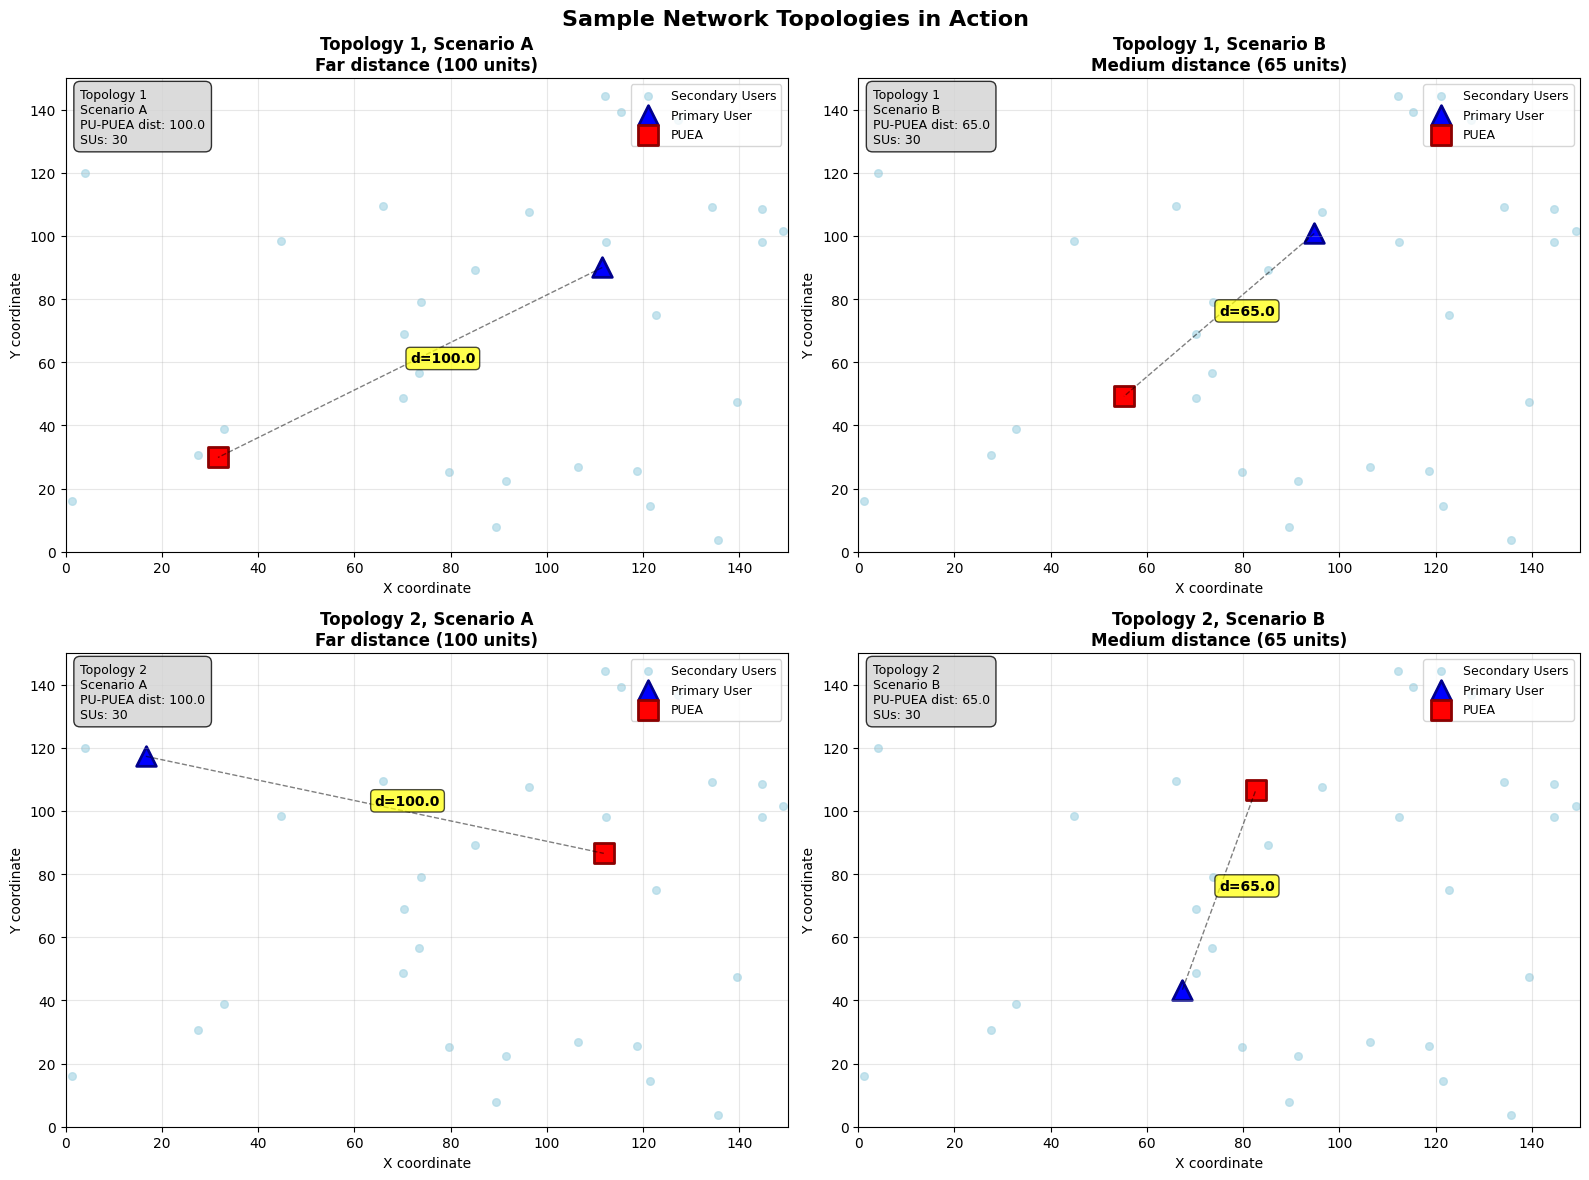

✅ Sample topology visualization saved to: integrated_topology_results/visualizations/sample_topologies.png

📊 MANHATTAN DISTANCE MATRIX DEMONSTRATION
--------------------------------------------------
Creating sample PU and PUEA feature data...
PU features (3 samples):
  PU Sample 1: Mean=0.50, Variance=0.20, Median=0.40, Q1=0.30, Q3=0.60
  PU Sample 2: Mean=0.60, Variance=0.30, Median=0.50, Q1=0.40, Q3=0.70
  PU Sample 3: Mean=0.40, Variance=0.10, Median=0.30, Q1=0.20, Q3=0.50

PUEA features (3 samples):
  PUEA Sample 1: Mean=0.80, Variance=0.40, Median=0.70, Q1=0.60, Q3=0.90
  PUEA Sample 2: Mean=0.90, Variance=0.50, Median=0.80, Q1=0.70, Q3=1.00
  PUEA Sample 3: Mean=0.70, Variance=0.30, Median=0.60, Q1=0.50, Q3=0.80

📏 Manhattan Distance Matrix (6x6 - 3 PU + 3 PUEA):
Rows/Cols: PU1, PU2, PU3, PUEA1, PUEA2, PUEA3
[[0.  0.5 0.5 1.4 1.9 0.9]
 [0.5 0.  1.  0.9 1.4 0.4]
 [0.5 1.  0.  1.9 2.4 1.4]
 [1.4 0.9 1.9 0.  0.5 0.5]
 [1.9 1.4 2.4 0.5 0.  1. ]
 [0.9 0.4 1.4 0.5 1.  0. ]]

📈 Distan

In [ ]:
# Sample Topology Visualization - First 2 Topologies, First 2 Scenarios
print(f"\n{'='*80}")
print("📍 SAMPLE TOPOLOGY VISUALIZATION")
print(f"{'='*80}")
print("Generating sample visualizations for first 2 topologies and first 2 scenarios...")

def visualize_sample_topologies():
    """Create sample visualizations for the first 2 topologies and scenarios A & B"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Sample Network Topologies in Action', fontsize=16, fontweight='bold')

    sample_topologies = [0, 1]  # First 2 topologies
    sample_scenarios = ['A', 'B']  # First 2 scenarios

    for i, topology_id in enumerate(sample_topologies):
        for j, scenario_name in enumerate(sample_scenarios):
            ax = axes[i, j]

            # Set unique seed for this topology
            topology_seed = topology_id * 1000
            np.random.seed(topology_seed)

            # Define target distances for each scenario (same as in main simulation)
            target_distances = {
                'A': 100.0,  # Far distance
                'B': 65.0,  # Medium distance
                'C': 25.0   # Close distance
            }

            # Generate scenarios with fixed distances but varying positions (same as main simulation)
            scenarios = {}

            for scen_name, target_distance in target_distances.items():
                if scen_name in ['A', 'B']:  # Only process A and B for visualization
                    # Generate random center position for this topology-scenario combination
                    center_x = np.random.uniform(target_distance + 10, AREA_SIZE - target_distance - 10)
                    center_y = np.random.uniform(target_distance + 10, AREA_SIZE - target_distance - 10)

                    # Generate random angle for this topology-scenario combination
                    angle = np.random.uniform(0, 2 * np.pi)

                    # Calculate PU and PUEA positions at exact target distance
                    half_distance = target_distance / 2
                    primary_position = np.array([
                        center_x - half_distance * np.cos(angle),
                        center_y - half_distance * np.sin(angle)
                    ])
                    puea_position = np.array([
                        center_x + half_distance * np.cos(angle),
                        center_y + half_distance * np.sin(angle)
                    ])

                    # Ensure positions are within bounds
                    primary_position = np.clip(primary_position, 10, AREA_SIZE - 10)
                    puea_position = np.clip(puea_position, 10, AREA_SIZE - 10)

                    # Store scenario with description
                    distance_descriptions = {
                        'A': f'Far distance ({target_distance:.0f} units)',
                        'B': f'Medium distance ({target_distance:.0f} units)'
                    }

                    scenarios[scen_name] = {
                        'primary_position': primary_position,
                        'puea_position': puea_position,
                        'target_distance': target_distance,
                        'description': distance_descriptions[scen_name]
                    }

            scenario_config = scenarios[scenario_name]
            primary_position = scenario_config['primary_position']
            puea_position = scenario_config['puea_position']
            pu_puea_distance = calculate_distance(primary_position, puea_position)

            # Use the same fixed secondary user positions as in main simulation (constant across all topologies and scenarios)
            np.random.seed(12345)  # Same fixed seed as in main simulation
            secondary_positions = np.random.uniform(0, AREA_SIZE, size=(NUM_SECONDARY_USERS, 2))

            # Plot secondary users
            ax.scatter(secondary_positions[:, 0], secondary_positions[:, 1],
                      c='lightblue', marker='o', s=30, alpha=0.7, label='Secondary Users')

            # Plot primary user and PUEA
            ax.scatter(primary_position[0], primary_position[1],
                      c='blue', marker='^', s=200, label='Primary User', edgecolors='darkblue', linewidth=2)
            ax.scatter(puea_position[0], puea_position[1],
                      c='red', marker='s', s=200, label='PUEA', edgecolors='darkred', linewidth=2)

            # Draw line between PU and PUEA to show distance
            ax.plot([primary_position[0], puea_position[0]],
                   [primary_position[1], puea_position[1]],
                   'k--', alpha=0.5, linewidth=1)

            # Add distance annotation
            mid_x = (primary_position[0] + puea_position[0]) / 2
            mid_y = (primary_position[1] + puea_position[1]) / 2
            ax.annotate(f'd={pu_puea_distance:.1f}',
                       (mid_x, mid_y), fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

            # Formatting
            ax.set_title(f'Topology {topology_id + 1}, Scenario {scenario_name}\n{scenario_config["description"]}',
                        fontweight='bold', fontsize=12)
            ax.set_xlabel('X coordinate')
            ax.set_ylabel('Y coordinate')
            ax.set_xlim(0, AREA_SIZE)
            ax.set_ylim(0, AREA_SIZE)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=9)

            # Add topology info text
            info_text = f"Topology {topology_id + 1}\nScenario {scenario_name}\nPU-PUEA dist: {pu_puea_distance:.1f}\nSUs: {NUM_SECONDARY_USERS}"
            ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=9,
                   verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

            print(f"✅ Topology {topology_id + 1}, Scenario {scenario_name}: PU-PUEA distance = {pu_puea_distance:.2f}")

    plt.tight_layout()

    # Save the visualization
    sample_viz_file = os.path.join(main_results_dir, "visualizations", "sample_topologies.png")
    plt.savefig(sample_viz_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Sample topology visualization saved to: {sample_viz_file}")

def demonstrate_distance_matrix_features():
    """Demonstrate how Manhattan distance matrix works with sample data"""

    print(f"\n📊 MANHATTAN DISTANCE MATRIX DEMONSTRATION")
    print("-" * 50)

    # Create sample feature data to demonstrate distance matrix calculation
    print("Creating sample PU and PUEA feature data...")

    # Sample PU features (simulated statistical features)
    pu_sample_features = np.array([
        [0.5, 0.2, 0.4, 0.3, 0.6],  # Mean, Var, Median, Q1, Q3
        [0.6, 0.3, 0.5, 0.4, 0.7],
        [0.4, 0.1, 0.3, 0.2, 0.5]
    ])

    # Sample PUEA features (different characteristics)
    puea_sample_features = np.array([
        [0.8, 0.4, 0.7, 0.6, 0.9],
        [0.9, 0.5, 0.8, 0.7, 1.0],
        [0.7, 0.3, 0.6, 0.5, 0.8]
    ])

    print(f"PU features (3 samples):")
    feature_names = ['Mean', 'Variance', 'Median', 'Q1', 'Q3']
    for i, features in enumerate(pu_sample_features):
        print(f"  PU Sample {i+1}: " + ", ".join([f"{name}={val:.2f}" for name, val in zip(feature_names, features)]))

    print(f"\nPUEA features (3 samples):")
    for i, features in enumerate(puea_sample_features):
        print(f"  PUEA Sample {i+1}: " + ", ".join([f"{name}={val:.2f}" for name, val in zip(feature_names, features)]))

    # Combine features and calculate distance matrix
    combined_features = np.vstack((pu_sample_features, puea_sample_features))
    distance_matrix = calculate_manhattan_distance_matrix(combined_features)

    print(f"\n📏 Manhattan Distance Matrix (6x6 - 3 PU + 3 PUEA):")
    print("Rows/Cols: PU1, PU2, PU3, PUEA1, PUEA2, PUEA3")
    print(distance_matrix)

    # Analyze the distance patterns
    print(f"\n📈 Distance Analysis:")
    pu_internal_distances = distance_matrix[0:3, 0:3]
    puea_internal_distances = distance_matrix[3:6, 3:6]
    pu_puea_distances = distance_matrix[0:3, 3:6]

    print(f"• Average distance within PU samples: {np.mean(pu_internal_distances[pu_internal_distances > 0]):.3f}")
    print(f"• Average distance within PUEA samples: {np.mean(puea_internal_distances[puea_internal_distances > 0]):.3f}")
    print(f"• Average distance between PU and PUEA: {np.mean(pu_puea_distances):.3f}")

    # Show how this helps in clustering
    print(f"\n🎯 Clustering Insight:")
    print(f"• PU samples are closer to each other (similarity within class)")
    print(f"• PUEA samples are closer to each other (similarity within class)")
    print(f"• PU and PUEA samples are farther apart (separability between classes)")
    print(f"• This distance pattern enables effective clustering and classification")

# Execute the demonstrations
visualize_sample_topologies()
demonstrate_distance_matrix_features()

print(f"\n{'='*80}")
print("✅ SAMPLE TOPOLOGY DEMONSTRATIONS COMPLETED")
print(f"{'='*80}")
print("Key observations:")
print("• Each topology generates different PU and PUEA positions")
print("• Statistical features capture signal characteristics")
print("• Manhattan distance matrix shows separability between PU and PUEA")
print("• Different scenarios (A, B, C) create varying levels of detection difficulty")


📊 CREATING TOPOLOGY-SPECIFIC CSV FILES AND AVERAGE TABLES
🚀 Starting topology CSV creation and analysis...
✅ Loaded 10,125 result records
  Processing Topology 1...
    ✅ Saved: integrated_topology_results/topology_csv_files/topology_01_results.csv
  Processing Topology 2...
    ✅ Saved: integrated_topology_results/topology_csv_files/topology_02_results.csv
  Processing Topology 3...
    ✅ Saved: integrated_topology_results/topology_csv_files/topology_03_results.csv
  Processing Topology 4...
    ✅ Saved: integrated_topology_results/topology_csv_files/topology_04_results.csv
  Processing Topology 5...
    ✅ Saved: integrated_topology_results/topology_csv_files/topology_05_results.csv
  Processing Topology 6...
    ✅ Saved: integrated_topology_results/topology_csv_files/topology_06_results.csv
  Processing Topology 7...
    ✅ Saved: integrated_topology_results/topology_csv_files/topology_07_results.csv
  Processing Topology 8...
    ✅ Saved: integrated_topology_results/topology_csv_fil

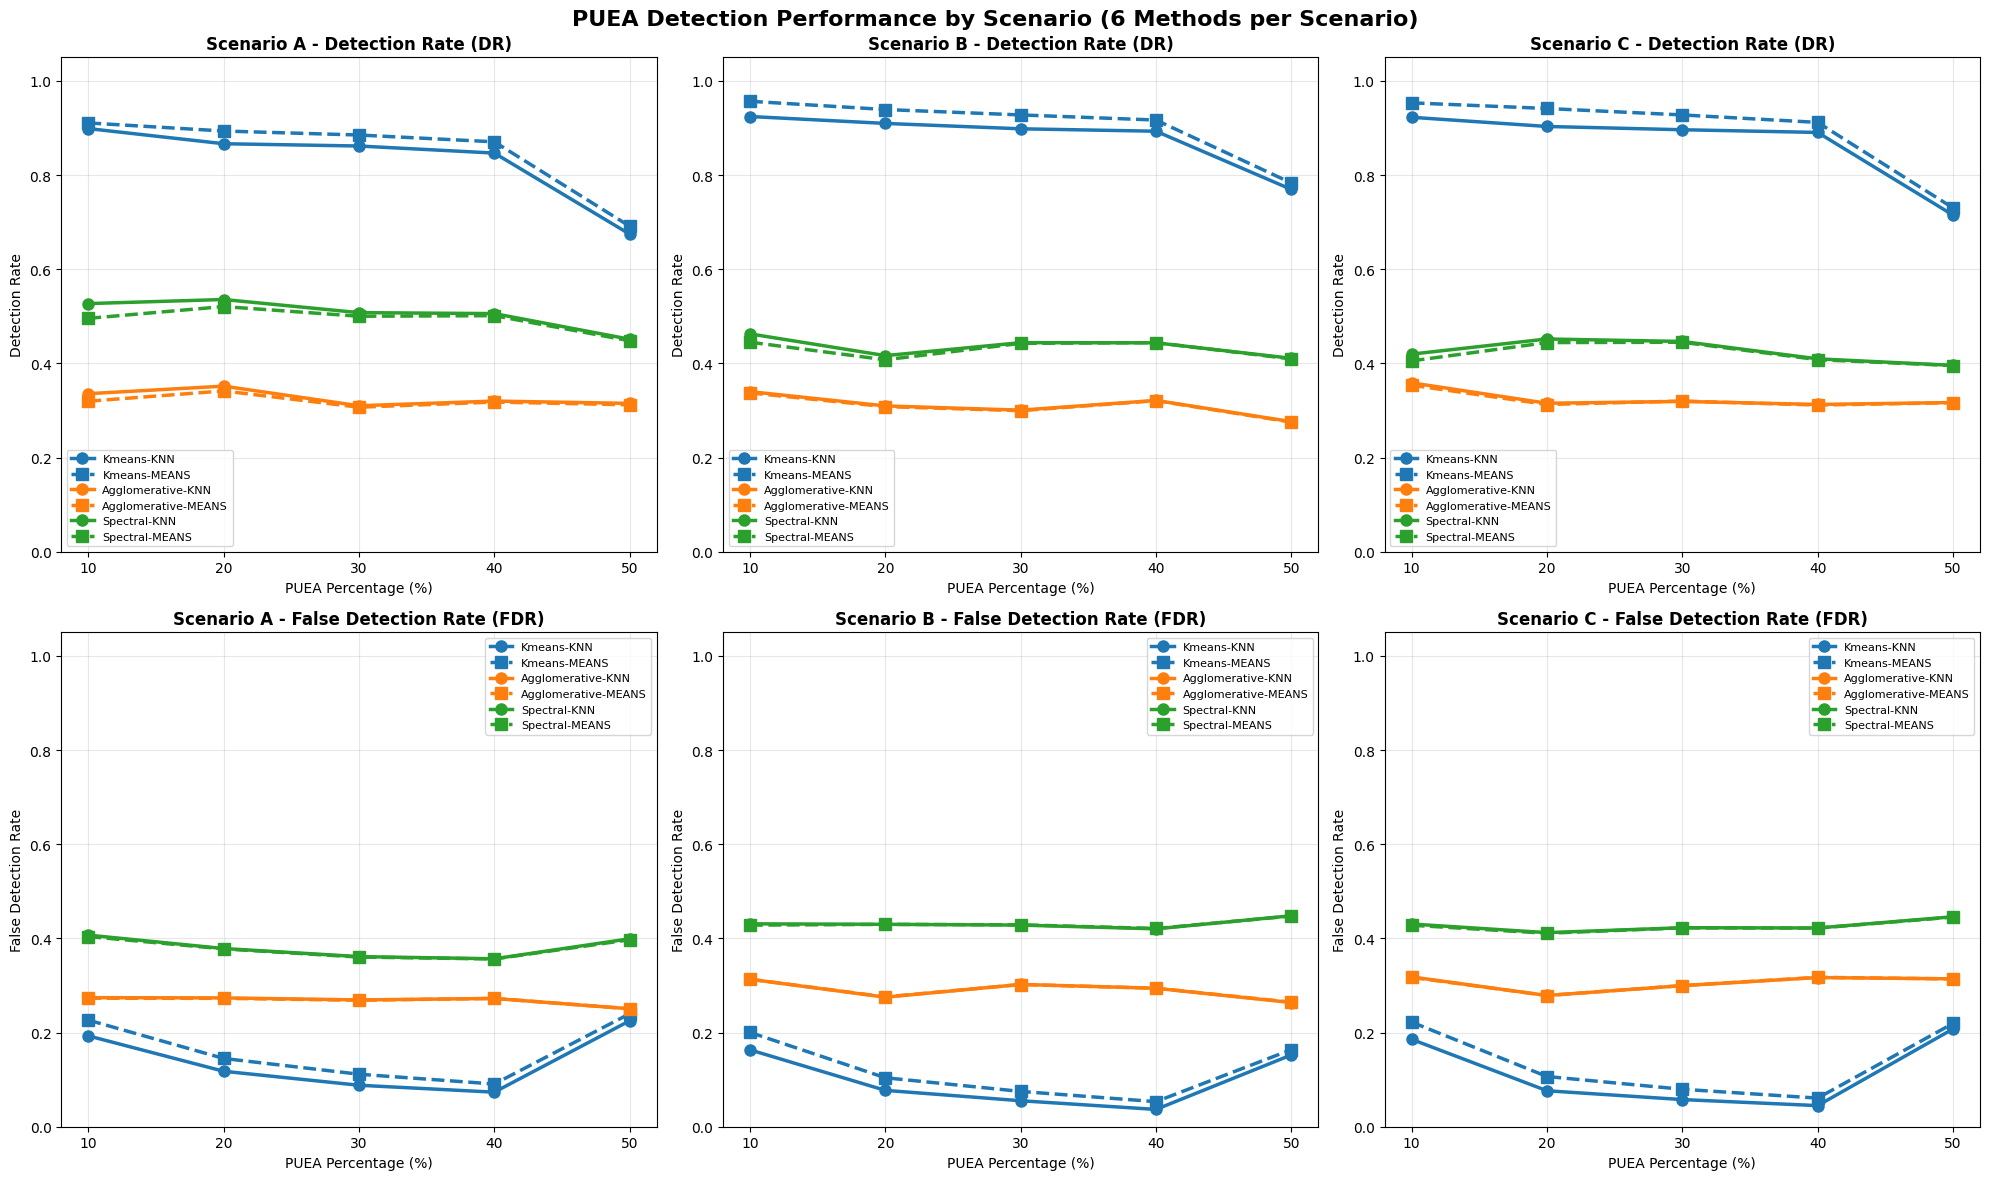

✅ Scenario-specific visualization saved: integrated_topology_results/visualizations/scenario_specific_performance_comparison.png

📊 Scenario Summary:
   • Scenario A: Far distance (70 units) - More challenging detection
   • Scenario B: Medium distance (40 units) - Moderate detection difficulty
   • Scenario C: Close distance (20 units) - Easier detection
   • Each scenario shows 6 lines: 3 clustering methods × 2 classification methods
   • Line styles: Solid (KNN), Dashed (Means)
   • Colors: Blue (K-means), Orange (Agglomerative), Green (Spectral)


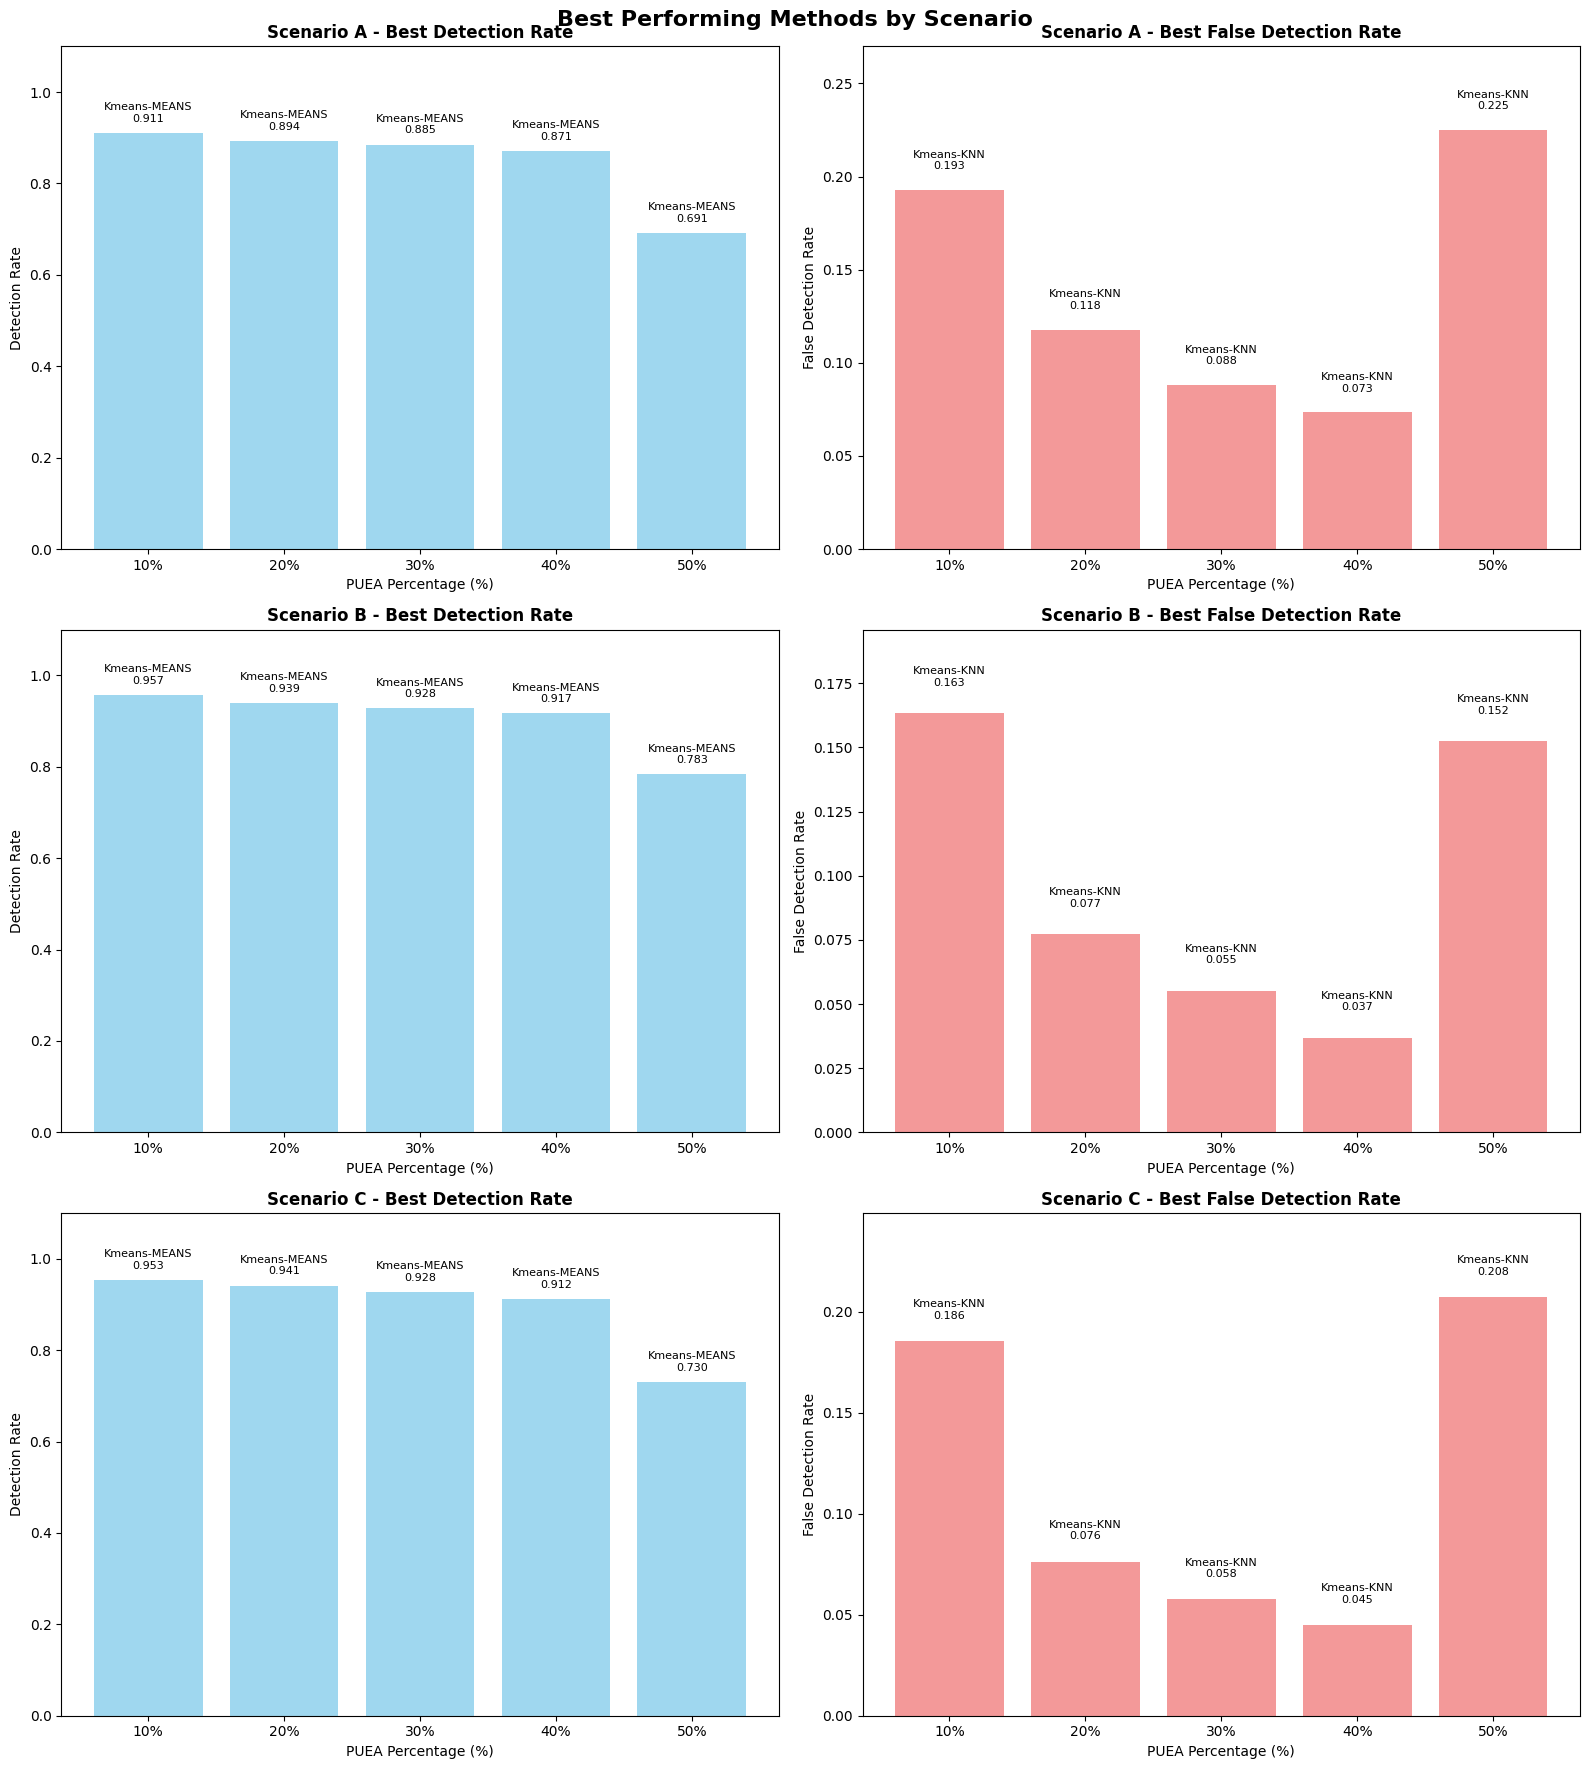

✅ Scenario summary visualization saved: integrated_topology_results/visualizations/scenario_best_methods_summary.png

📈 SCENARIO ANALYSIS SUMMARY:
------------------------------------------------------------

🎯 Scenario A: 70 units (Far distance - Most challenging)
   Best overall method: Kmeans-MEANS (DR: 0.850)

🎯 Scenario B: 40 units (Medium distance - Moderate difficulty)
   Best overall method: Kmeans-MEANS (DR: 0.905)

🎯 Scenario C: 20 units (Close distance - Least challenging)
   Best overall method: Kmeans-MEANS (DR: 0.893)

💡 Key Insights:
   • Each scenario represents different PU-PUEA distance configurations
   • 6 methods tested per scenario: 3 clustering × 2 classification (KNN, Means)
   • Line styles distinguish classification: Solid (KNN), Dashed (Means)
   • Colors distinguish clustering: Blue (K-means), Orange (Agglomerative), Green (Spectral)

✅ ENHANCED TOPOLOGY CSV FILES AND ANALYSIS COMPLETED
📁 Files created:
   • Individual topology CSVs (with all classification 

In [ ]:
# Create Individual Topology CSV Files and Average Tables
print(f"\n{'='*80}")
print("📊 CREATING TOPOLOGY-SPECIFIC CSV FILES AND AVERAGE TABLES")
print(f"{'='*80}")

def create_topology_table_structure():
    """Create the table structure with all classification methods"""
    # Define the structure: PUEA %on PU vs (Clustering Methods x Classification Methods x DR/FDR)
    puea_percentages = [10, 20, 30, 40, 50]
    clustering_methods = ['kmeans', 'agglomerative', 'spectral']
    classification_methods = ['original', 'knn', 'means']
    metrics = ['DR', 'FDR']

    # Create column headers
    columns = ['PUEA_%on_PU']
    for clustering_method in clustering_methods:
        for classification_method in classification_methods:
            for metric in metrics:
                col_name = f"{clustering_method.title()}_{classification_method.title()}_{metric}"
                columns.append(col_name)

    return columns, puea_percentages

def create_topology_csv_files():
    """Create individual CSV files for each topology following the image structure"""

    # Load complete results
    complete_file = os.path.join(main_results_dir, "topology_data", "complete_simulation_results.csv")

    if not os.path.exists(complete_file):
        print("❌ Complete results file not found. Please run the simulation first.")
        return None

    results_df = pd.read_csv(complete_file)
    print(f"✅ Loaded {len(results_df):,} result records")

    columns, puea_percentages = create_topology_table_structure()

    # Create directory for topology CSV files
    topology_csv_dir = os.path.join(main_results_dir, "topology_csv_files")
    if not os.path.exists(topology_csv_dir):
        os.makedirs(topology_csv_dir)

    # Process each topology
    all_topology_data = {}

    for topology_id in range(NUM_TOPOLOGIES):
        print(f"  Processing Topology {topology_id + 1}...")

        # Filter data for current topology (all classification methods)
        topology_data = results_df[results_df['topology_id'] == topology_id].copy()

        if topology_data.empty:
            print(f"    ⚠️ No data found for topology {topology_id + 1}")
            continue

        # Create table for this topology
        topology_table = []

        for percentage in puea_percentages:
            row = [f"{percentage}%"]

            # Get data for each clustering method and classification method
            for clustering_method in ['kmeans', 'agglomerative', 'spectral']:
                for classification_method in ['original', 'knn', 'means']:
                    # Filter for specific percentage, clustering method, and classification method
                    method_data = topology_data[
                        (topology_data['case_percentage'] == percentage) &
                        (topology_data['clustering_method'] == clustering_method) &
                        (topology_data['classification_method'] == classification_method)
                    ]

                    if not method_data.empty:
                        # Average across all scenarios (A, B, C) for this combination
                        avg_dr = method_data['detection_rate'].mean()
                        avg_fdr = method_data['false_detection_rate'].mean()
                        row.extend([f"{avg_dr:.4f}", f"{avg_fdr:.4f}"])
                    else:
                        row.extend(["0.0000", "0.0000"])

            topology_table.append(row)

        # Create DataFrame and save CSV
        topology_df = pd.DataFrame(topology_table, columns=columns)
        csv_filename = os.path.join(topology_csv_dir, f"topology_{topology_id + 1:02d}_results.csv")
        topology_df.to_csv(csv_filename, index=False)

        # Store for average calculation
        all_topology_data[topology_id] = topology_df

        print(f"    ✅ Saved: {csv_filename}")

    print(f"✅ Created {len(all_topology_data)} topology CSV files")
    return all_topology_data

def calculate_average_table(all_topology_data):
    """Calculate average values across all topologies"""

    if not all_topology_data:
        print("❌ No topology data available for averaging")
        return None

    print(f"\n📊 Calculating average table from {len(all_topology_data)} topologies...")

    columns, puea_percentages = create_topology_table_structure()

    # Initialize average table
    average_table = []

    for row_idx, percentage in enumerate(puea_percentages):
        avg_row = [f"{percentage}%"]

        # For each clustering method and metric
        for col_idx in range(1, len(columns)):  # Skip first column (PUEA_%)
            column_name = columns[col_idx]

            # Collect all values for this cell across all topologies
            values = []
            for topology_id, topology_df in all_topology_data.items():
                if row_idx < len(topology_df):
                    cell_value = topology_df.iloc[row_idx, col_idx]
                    try:
                        # Convert to float (remove % if present)
                        numeric_value = float(str(cell_value).replace('%', ''))
                        values.append(numeric_value)
                    except:
                        continue

            # Calculate average
            if values:
                avg_value = np.mean(values)
                avg_row.append(f"{avg_value:.4f}")
            else:
                avg_row.append("0.0000")

        average_table.append(avg_row)

    # Create average DataFrame
    average_df = pd.DataFrame(average_table, columns=columns)

    # Save average table
    average_csv_file = os.path.join(main_results_dir, "final_analysis", "average_topology_results.csv")
    average_df.to_csv(average_csv_file, index=False)

    print(f"✅ Average table saved: {average_csv_file}")
    print(f"\n📋 AVERAGE TABLE:")
    print(average_df.to_string(index=False))

    return average_df

def create_visualizations(average_df):
    """Create scenario-specific visualizations with 6 lines per scenario (3 clustering × 2 classification, excluding original)"""

    if average_df is None:
        print("❌ No average data available for visualization")
        return

    print(f"\n🎨 Creating scenario-specific visualizations for DR and FDR...")

    # Load complete results to calculate scenario-specific averages
    complete_file = os.path.join(main_results_dir, "topology_data", "complete_simulation_results.csv")
    results_df = pd.read_csv(complete_file)

    # Extract data for visualization
    puea_percentages = [10, 20, 30, 40, 50]
    clustering_methods = ['kmeans', 'agglomerative', 'spectral']
    classification_methods = ['knn', 'means']  # Exclude 'original'
    scenarios = ['A', 'B', 'C']

    # Create scenario-specific visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('PUEA Detection Performance by Scenario (6 Methods per Scenario)', fontsize=16, fontweight='bold')

    # Colors and markers for different clustering methods
    clustering_colors = {'kmeans': '#1f77b4', 'agglomerative': '#ff7f0e', 'spectral': '#2ca02c'}
    classification_markers = {'knn': 'o', 'means': 's'}
    classification_styles = {'knn': '-', 'means': '--'}

    # Plot DR for each scenario
    for scenario_idx, scenario in enumerate(scenarios):
        ax_dr = axes[0, scenario_idx]

        # Calculate scenario-specific averages
        scenario_data = results_df[results_df['scenario'] == scenario]

        for clustering_method in clustering_methods:
            for classification_method in classification_methods:
                # Filter data for this specific combination
                method_data = scenario_data[
                    (scenario_data['clustering_method'] == clustering_method) &
                    (scenario_data['classification_method'] == classification_method)
                ]

                # Calculate average DR for each PUEA percentage
                dr_values = []
                for percentage in puea_percentages:
                    percentage_data = method_data[method_data['case_percentage'] == percentage]
                    if not percentage_data.empty:
                        avg_dr = percentage_data['detection_rate'].mean()
                        dr_values.append(avg_dr)
                    else:
                        dr_values.append(0.0)

                # Create label and plot
                method_label = f"{clustering_method.title()}-{classification_method.upper()}"
                color = clustering_colors[clustering_method]
                marker = classification_markers[classification_method]
                linestyle = classification_styles[classification_method]

                ax_dr.plot(puea_percentages, dr_values,
                          marker=marker,
                          linewidth=2.5, markersize=8,
                          label=method_label,
                          color=color,
                          linestyle=linestyle)

        ax_dr.set_title(f'Scenario {scenario} - Detection Rate (DR)', fontweight='bold', fontsize=12)
        ax_dr.set_xlabel('PUEA Percentage (%)', fontsize=10)
        ax_dr.set_ylabel('Detection Rate', fontsize=10)
        ax_dr.set_xticks(puea_percentages)
        ax_dr.set_ylim(0, 1.05)
        ax_dr.legend(fontsize=8, loc='best')
        ax_dr.grid(True, alpha=0.3)

    # Plot FDR for each scenario
    for scenario_idx, scenario in enumerate(scenarios):
        ax_fdr = axes[1, scenario_idx]

        # Calculate scenario-specific averages
        scenario_data = results_df[results_df['scenario'] == scenario]

        for clustering_method in clustering_methods:
            for classification_method in classification_methods:
                # Filter data for this specific combination
                method_data = scenario_data[
                    (scenario_data['clustering_method'] == clustering_method) &
                    (scenario_data['classification_method'] == classification_method)
                ]

                # Calculate average FDR for each PUEA percentage
                fdr_values = []
                for percentage in puea_percentages:
                    percentage_data = method_data[method_data['case_percentage'] == percentage]
                    if not percentage_data.empty:
                        avg_fdr = percentage_data['false_detection_rate'].mean()
                        fdr_values.append(avg_fdr)
                    else:
                        fdr_values.append(0.0)

                # Create label and plot
                method_label = f"{clustering_method.title()}-{classification_method.upper()}"
                color = clustering_colors[clustering_method]
                marker = classification_markers[classification_method]
                linestyle = classification_styles[classification_method]

                ax_fdr.plot(puea_percentages, fdr_values,
                           marker=marker,
                           linewidth=2.5, markersize=8,
                           label=method_label,
                           color=color,
                           linestyle=linestyle)

        ax_fdr.set_title(f'Scenario {scenario} - False Detection Rate (FDR)', fontweight='bold', fontsize=12)
        ax_fdr.set_xlabel('PUEA Percentage (%)', fontsize=10)
        ax_fdr.set_ylabel('False Detection Rate', fontsize=10)
        ax_fdr.set_xticks(puea_percentages)
        ax_fdr.set_ylim(0, 1.05)
        ax_fdr.legend(fontsize=8, loc='best')
        ax_fdr.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save scenario-specific visualization
    viz_file = os.path.join(main_results_dir, "visualizations", "scenario_specific_performance_comparison.png")
    plt.savefig(viz_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Scenario-specific visualization saved: {viz_file}")

    # Print summary of what each scenario represents
    print(f"\n📊 Scenario Summary:")
    print(f"   • Scenario A: Far distance (70 units) - More challenging detection")
    print(f"   • Scenario B: Medium distance (40 units) - Moderate detection difficulty")
    print(f"   • Scenario C: Close distance (20 units) - Easier detection")
    print(f"   • Each scenario shows 6 lines: 3 clustering methods × 2 classification methods")
    print(f"   • Line styles: Solid (KNN), Dashed (Means)")
    print(f"   • Colors: Blue (K-means), Orange (Agglomerative), Green (Spectral)")

    # Create scenario comparison summary chart
    fig2, axes2 = plt.subplots(3, 2, figsize=(16, 18))
    fig2.suptitle('Best Performing Methods by Scenario', fontsize=16, fontweight='bold')

    # For each scenario, find best performing method for each percentage
    for scenario_idx, scenario in enumerate(scenarios):
        scenario_data = results_df[results_df['scenario'] == scenario]

        # Best DR methods for this scenario
        ax_dr_scenario = axes2[scenario_idx, 0]
        best_dr_methods = []
        best_dr_values = []

        for percentage in puea_percentages:
            best_dr = 0
            best_method = ""

            for clustering in clustering_methods:
                for classification in classification_methods:
                    method_data = scenario_data[
                        (scenario_data['case_percentage'] == percentage) &
                        (scenario_data['clustering_method'] == clustering) &
                        (scenario_data['classification_method'] == classification)
                    ]

                    if not method_data.empty:
                        value = method_data['detection_rate'].mean()
                        if value > best_dr:
                            best_dr = value
                            best_method = f"{clustering.title()}-{classification.upper()}"

            best_dr_methods.append(best_method)
            best_dr_values.append(best_dr)

        # Plot best DR methods for this scenario
        bars_dr = ax_dr_scenario.bar(range(len(puea_percentages)), best_dr_values, color='skyblue', alpha=0.8)
        ax_dr_scenario.set_title(f'Scenario {scenario} - Best Detection Rate', fontweight='bold')
        ax_dr_scenario.set_xlabel('PUEA Percentage (%)')
        ax_dr_scenario.set_ylabel('Detection Rate')
        ax_dr_scenario.set_xticks(range(len(puea_percentages)))
        ax_dr_scenario.set_xticklabels([f"{p}%" for p in puea_percentages])
        ax_dr_scenario.set_ylim(0, 1.1)

        # Add method labels and values
        for i, (bar, method, value) in enumerate(zip(bars_dr, best_dr_methods, best_dr_values)):
            ax_dr_scenario.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                    f'{method}\n{value:.3f}', ha='center', va='bottom', fontsize=8)

        # Best FDR methods for this scenario
        ax_fdr_scenario = axes2[scenario_idx, 1]
        best_fdr_methods = []
        best_fdr_values = []

        for percentage in puea_percentages:
            best_fdr = float('inf')
            best_method = ""

            for clustering in clustering_methods:
                for classification in classification_methods:
                    method_data = scenario_data[
                        (scenario_data['case_percentage'] == percentage) &
                        (scenario_data['clustering_method'] == clustering) &
                        (scenario_data['classification_method'] == classification)
                    ]

                    if not method_data.empty:
                        value = method_data['false_detection_rate'].mean()
                        if value < best_fdr:
                            best_fdr = value
                            best_method = f"{clustering.title()}-{classification.upper()}"

            best_fdr_methods.append(best_method)
            best_fdr_values.append(best_fdr)

        # Plot best FDR methods for this scenario
        bars_fdr = ax_fdr_scenario.bar(range(len(puea_percentages)), best_fdr_values, color='lightcoral', alpha=0.8)
        ax_fdr_scenario.set_title(f'Scenario {scenario} - Best False Detection Rate', fontweight='bold')
        ax_fdr_scenario.set_xlabel('PUEA Percentage (%)')
        ax_fdr_scenario.set_ylabel('False Detection Rate')
        ax_fdr_scenario.set_xticks(range(len(puea_percentages)))
        ax_fdr_scenario.set_xticklabels([f"{p}%" for p in puea_percentages])
        ax_fdr_scenario.set_ylim(0, max(best_fdr_values) * 1.2 if best_fdr_values else 1)

        # Add method labels and values
        for i, (bar, method, value) in enumerate(zip(bars_fdr, best_fdr_methods, best_fdr_values)):
            ax_fdr_scenario.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{method}\n{value:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()

    # Save scenario summary visualization
    scenario_summary_viz_file = os.path.join(main_results_dir, "visualizations", "scenario_best_methods_summary.png")
    plt.savefig(scenario_summary_viz_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Scenario summary visualization saved: {scenario_summary_viz_file}")

    # Print detailed scenario analysis
    print(f"\n📈 SCENARIO ANALYSIS SUMMARY:")
    print("-" * 60)

    distance_info = {
        'A': '70 units (Far distance - Most challenging)',
        'B': '40 units (Medium distance - Moderate difficulty)',
        'C': '20 units (Close distance - Least challenging)'
    }

    for scenario in scenarios:
        print(f"\n🎯 Scenario {scenario}: {distance_info[scenario]}")
        scenario_data = results_df[results_df['scenario'] == scenario]

        # Overall best method for this scenario (across all percentages)
        overall_best_dr = 0
        overall_best_method = ""

        for clustering in clustering_methods:
            for classification in classification_methods:
                method_data = scenario_data[
                    (scenario_data['clustering_method'] == clustering) &
                    (scenario_data['classification_method'] == classification)
                ]

                if not method_data.empty:
                    avg_dr = method_data['detection_rate'].mean()
                    if avg_dr > overall_best_dr:
                        overall_best_dr = avg_dr
                        overall_best_method = f"{clustering.title()}-{classification.upper()}"

        print(f"   Best overall method: {overall_best_method} (DR: {overall_best_dr:.3f})")

    print(f"\n💡 Key Insights:")
    print(f"   • Each scenario represents different PU-PUEA distance configurations")
    print(f"   • 6 methods tested per scenario: 3 clustering × 2 classification (KNN, Means)")
    print(f"   • Line styles distinguish classification: Solid (KNN), Dashed (Means)")
    print(f"   • Colors distinguish clustering: Blue (K-means), Orange (Agglomerative), Green (Spectral)")

# Execute the complete process
print("🚀 Starting topology CSV creation and analysis...")

# Step 1: Create individual topology CSV files
all_topology_data = create_topology_csv_files()

# Step 2: Calculate average table
average_df = calculate_average_table(all_topology_data)

# Step 3: Create visualizations
create_visualizations(average_df)

print(f"\n{'='*80}")
print("✅ ENHANCED TOPOLOGY CSV FILES AND ANALYSIS COMPLETED")
print(f"{'='*80}")
print("📁 Files created:")
print(f"   • Individual topology CSVs (with all classification methods): {main_results_dir}/topology_csv_files/")
print(f"   • Average table CSV (with all classification methods): {main_results_dir}/final_analysis/average_topology_results.csv")
print(f"   • Comprehensive DR & FDR visualizations: {main_results_dir}/visualizations/")
print("\n🎯 Summary:")
print(f"   • Created {NUM_TOPOLOGIES} individual topology CSV files")
print(f"   • Each topology includes 3 clustering × 3 classification methods = 9 method combinations")
print(f"   • Calculated average performance across all topologies")
print(f"   • Generated comprehensive visualizations showing all method combinations")
print(f"   • Enhanced structure: Topology → Clustering → Classification → DR & FDR")

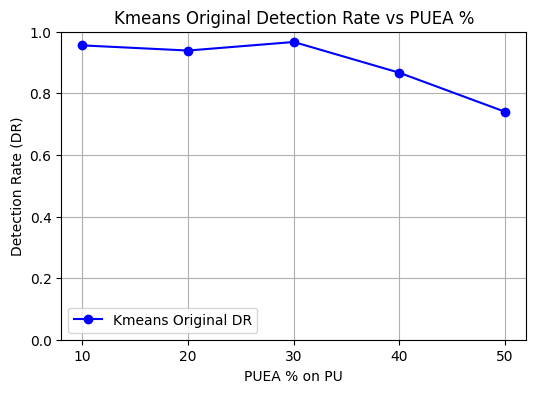

In [ ]:
import matplotlib.pyplot as plt
puea_percent = [10, 20, 30, 40, 50]
kmeans_dr = [0.9556, 0.9389, 0.9667, 0.8667, 0.7400]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(puea_percent, kmeans_dr, marker='o', linestyle='-', color='blue', label='Kmeans Original DR')

# Labels and limits
plt.xlabel('PUEA % on PU')
plt.ylabel('Detection Rate (DR)')
plt.title('Kmeans Original Detection Rate vs PUEA %')
plt.xticks(puea_percent)
plt.ylim(0, 1)  # detection rate range from 0 to 1
plt.grid(True)
plt.legend()
plt.show()